In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print('Location:', torch.__file__) # /home/emre/.local/lib/python3.7/site-packages

1.9.0+cu111
True
11.1
Location: C:\Users\emrek\anaconda3\envs\tensorflow25\lib\site-packages\torch\__init__.py


In [2]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

In [3]:
import warnings
warnings.filterwarnings("ignore")
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torchsummary import summary
import torchvision
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax

In [4]:
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
def load_pkl(filename):
    with open(filename, 'rb') as input:
        data = pickle.load(input)
    return data

In [20]:
[train_images, train_vids, train_skels, train_labels,
 test_images, test_vids, test_skels, test_labels] = load_pkl('datasets\ASL_10_vid_skel_mDsim.pkl')
train_images = np.swapaxes(train_images.astype(np.float64), 1, -1)
test_images = np.swapaxes(test_images.astype(np.float64), 1, -1)
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(210, 3, 128, 128)
(210,)
(55, 3, 128, 128)
(55,)


## Dataloader

In [21]:
class CustomImageDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        temp_x = torch.tensor(self.x[idx], dtype=torch.float)
        temp_y = torch.tensor(self.y[idx], dtype=torch.long)
#         self.x = self.x[idx]
#         self.y = self.y[idx]
#         return self.x[idx], self.y[idx] 
        return temp_x, temp_y

## Hyperparams

In [22]:
batch_size = 32

## Classify mD

In [23]:
training_data = CustomImageDataset(torch.from_numpy(train_images), torch.from_numpy(train_labels))
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
testing_data = CustomImageDataset(torch.from_numpy(test_images), torch.from_numpy(test_labels))
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)

In [24]:
training_features, training_labels = next(iter(train_loader))
print(f"Feature batch shape: {training_features.size()}")
print(f"Labels batch shape: {training_labels.size()}")

Feature batch shape: torch.Size([32, 3, 128, 128])
Labels batch shape: torch.Size([32])


In [25]:
# iterate through the dataset:
for i, batch in enumerate(test_loader):
    print(f'{i}', '. batch length:', f'{len(batch[0])}')

0 . batch length: 32
1 . batch length: 23


In [26]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv11 = nn.Conv2d(64, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv21 = nn.Conv2d(128, 128, 3)
        self.conv3 = nn.Conv2d(128, 128, 3)
        self.conv31 = nn.Conv2d(128, 128, 3)
#         self.conv4 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(14*14*128, 128) # 3 layers: 14*14*128, 4 layers: 6*6*128
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         x = F.relu(self.conv11(x))
        x = self.pool(F.relu(self.conv2(x)))
#         x = F.relu(self.conv21(x))
        x = self.pool(F.relu(self.conv3(x)))
#         x = F.relu(self.conv31(x))
#         x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.softmax(self.fc3(x))
        return x

In [27]:
def train( model, model_name, prog_bar = True):
    
    max_test_acc = 0.0
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        train_acc = []
        test_acc = []
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
            
        # train
        for data in pbar:
            x, labels = data
            x = x.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            preds = np.argmax(out.cpu().detach().numpy(), -1)
            labels = labels.cpu().detach().numpy()
            acc = np.sum(preds == labels) / len(labels) * 100
            train_acc.append(acc)
            if prog_bar:
                pbar.set_description('Train_acc: '+str(round(acc,2)))
        train_accs.append(np.mean(train_acc))
        
        # test
        all_preds = []
        for data in test_loader:
            x, labels = data
            x = x.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, labels)
            preds = np.argmax(out.cpu().detach().numpy(), -1)
            labels = labels.cpu().detach().numpy()
            acc = np.sum(preds == labels) / len(labels) * 100
            test_acc.append(acc)
            all_preds.append(preds)
        test_accs.append(np.mean(test_acc))
        
        if np.mean(test_acc) > max_test_acc:
#             print(np.array(all_preds[0]).shape)
#             print(np.array(all_preds[1]).shape)
            best_preds = [i for a in all_preds for i in a]
            max_test_acc = np.mean(test_acc)
            torch.save(model.state_dict(), 'models\\' + model_name + str(round(max_test_acc, 2)) + '.pth')
        
#         lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Acc: ', round(np.mean(train_acc), 2), '| Testing Acc: ', round(np.mean(test_acc), 2))
#         train_losses.append(train_loss)
#         test_losses.append(test_loss)

        
        if not prog_bar:
            clear_output(wait=True)
            print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Acc: ', round(np.mean(train_acc), 2), '| Testing Acc: ', round(np.mean(test_acc), 2),
                 ', Best Testing Acc:', max_test_acc)
            plt.plot(train_accs, label="Train Acc")
            plt.plot(test_accs, label="Validation Acc")
            plt.xlabel("# Epoch")
            plt.ylabel("Accuracy")
            plt.legend(loc='upper right')
            plt.show()
    return best_preds

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
summary(model, (3, 128, 128))
print('device:', device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 126]           1,792
         MaxPool2d-2           [-1, 64, 63, 63]               0
            Conv2d-3          [-1, 128, 61, 61]          73,856
         MaxPool2d-4          [-1, 128, 30, 30]               0
            Conv2d-5          [-1, 128, 28, 28]         147,584
         MaxPool2d-6          [-1, 128, 14, 14]               0
           Dropout-7                [-1, 25088]               0
            Linear-8                  [-1, 128]       3,211,392
           Dropout-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 3,452,426
Trainable params: 3,452,426
Non-trainable params: 0
---------------------------

Epoch:  500/500 | Training Acc:  85.47 | Testing Acc:  37.02 , Best Testing Acc: 54.211956521739125


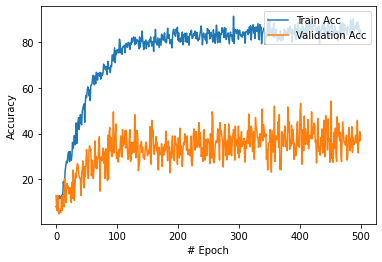

In [29]:
model_name = 'model_cnn_mDsim_acc'
epochs = 500
best_preds = train(model, model_name, prog_bar = False)

# ResNet-50

In [20]:
resnet = torchvision.models.resnet50(pretrained=False).to(device)

In [21]:
resnet.fc = torch.nn.Sequential(
    nn.Linear(
        in_features=2048,
        out_features=10
    ),
    nn.Softmax()
).to(device)

In [22]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch:  8/200 | Training Acc:  8.93 | Testing Acc:  8.42 , Best Testing Acc: 10.869565217391305


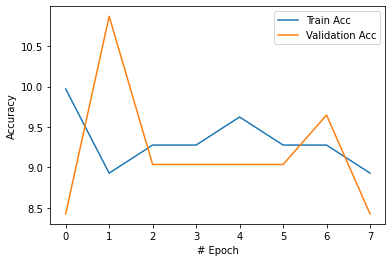

KeyboardInterrupt: 

In [23]:
model_name = 'model_resnet50_mDreal_acc'
epochs = 200
best_preds = train(resnet, model_name, prog_bar = False)